<a href="https://colab.research.google.com/github/JiaxinLi-lipluszn/Temp_notebooks/blob/main/Attention_scRNA_128%2B128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/scRNA/Stoeckiues")


In [3]:
import sys
import argparse

import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms
from torchvision import models as torchvision_models
import pandas as pd
from torch.utils.data import Dataset
from functools import partial
import numpy as np
from torch import optim
from pathlib import Path
from torch.autograd import Variable

import os
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
import math
from functools import partial

import torch
import torch.nn as nn


import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

In [4]:
import utils
import vision_transformer_sc as vits
from utils import trunc_normal_

In [ ]:
data_path = "/content/drive/MyDrive/dino_perturb/"

In [5]:
class scRNACSV(Dataset):
  def __init__(self, expr, meta, transform = None, target_transform=None):
    self.expr = expr
    self.meta = meta
    self.cells = list(expr.columns)
    self.labels = list(meta["perturb"])
    self.samples = [(self.cells,self.labels[i]) for i in range(len(self.labels))]
    self.label_keys = list(set(self.labels))
    self.label_keys.sort()
    self.label_dic = {}
    for label, i in zip(self.label_keys, range(len(self.label_keys))):
      self.label_dic[label] = i
    print(f"This is the label dictionary of this dataset {self.label_dic}")
    self.transform = transform
    self.target_transform = target_transform
  def __len__(self):
    return self.expr.shape[1]

  def __getitem__(self,idx):
    one_cell = torch.from_numpy(np.array(self.expr.iloc[:,idx]))
    if self.transform:
      ret = self.transform(one_cell)
      print("Use transform")
    else:
      ret = one_cell
    lab = self.label_dic[self.labels[idx]]
    print(f"This is the label {lab}")
    
    return ret, self.label_dic[self.labels[idx]]

In [5]:
newdata = pd.read_csv("/content/drive/MyDrive/scRNA/data/rna_withlabels.csv", index_col=0)

In [ ]:
newdata.columns[-1]

'celltype.l1.5'

In [6]:
meta = pd.DataFrame(newdata[newdata.columns[-1]])

In [7]:
meta.columns = ["perturb"]

In [8]:
expr = newdata.drop(newdata.columns[-1], axis  = 1)

In [9]:
expr = expr.transpose()

In [12]:
expr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,30632,30633,30634,30635,30636,30637,30638,30639,30640,30641,30642,30643,30644,30645,30646,30647,30648,30649,30650,30651,30652,30653,30654,30655,30656,30657,30658,30659,30660,30661,30662,30663,30664,30665,30666,30667,30668,30669,30670,30671
IGKC,-0.428204,-1.047339,-1.047339,0.080052,0.953832,1.982183,0.091750,-1.047339,1.974582,-1.047339,-1.047339,-1.047339,0.615770,0.236480,-1.047339,-1.047339,-1.047339,0.636896,0.717112,0.484105,0.644306,0.275043,-1.047339,0.138760,-1.047339,0.431264,0.634544,-1.047339,-1.047339,-1.047339,-0.277476,-1.047339,-1.047339,0.073376,0.763909,-1.047339,-1.047339,-1.047339,-1.047339,-1.047339,...,0.577773,1.423658,0.035011,-1.047339,0.008509,2.069583,0.740485,0.324261,-1.047339,-1.047339,0.111533,-1.047339,-0.021941,0.605155,0.425505,-1.047339,-0.372777,0.547710,0.328189,-1.047339,-1.047339,0.471091,-0.295642,-0.485430,-0.553826,0.154187,-0.056224,0.345608,-1.047339,0.633372,-0.035848,1.420359,-0.032248,-1.047339,0.036731,-1.047339,0.201403,-0.160723,0.527459,-1.047339
HBA2,0.183748,-0.601956,-0.601956,0.828744,-0.601956,-0.601956,-0.601956,-0.601956,1.986508,-0.601956,-0.601956,2.485121,-0.601956,-0.601956,0.816080,-0.601956,-0.601956,-0.601956,1.072269,-0.601956,-0.601956,1.076195,-0.601956,0.903247,-0.601956,-0.601956,0.680836,1.461387,1.430192,1.503913,-0.601956,-0.601956,-0.601956,-0.601956,1.126880,-0.601956,1.961798,-0.601956,-0.601956,-0.601956,...,0.911431,1.334623,-0.601956,-0.601956,-0.601956,0.658971,-0.601956,-0.601956,-0.601956,-0.601956,-0.601956,1.031659,-0.601956,-0.601956,0.739097,1.617395,0.759861,0.173073,-0.601956,-0.601956,-0.601956,1.324987,3.796624,0.111126,3.102697,-0.601956,1.172063,-0.601956,-0.601956,-0.601956,-0.601956,1.569027,1.206934,-0.601956,0.773768,0.763410,-0.601956,-0.601956,0.854063,-0.601956
HBB,0.406723,-0.985002,1.534527,0.614775,0.794895,0.735257,0.628270,0.813311,1.407617,0.693205,0.270060,3.013038,0.279269,0.337931,0.603243,0.528512,0.966455,1.528646,0.833206,-0.985002,-0.985002,1.120253,0.103014,0.237234,-0.985002,0.538649,-0.985002,-0.985002,-0.985002,1.711632,2.444574,1.042861,-0.985002,0.882302,-0.985002,1.112255,1.096784,0.670951,1.188875,0.932381,...,0.689622,-0.985002,-0.985002,-0.985002,0.103014,-0.985002,-0.985002,0.012749,0.889329,-0.985002,-0.985002,-0.985002,0.071636,0.031527,0.103943,0.359747,2.906844,-0.985002,-0.985002,-0.985002,-0.985002,-0.985002,4.010042,-0.985002,3.294616,-0.985002,0.036309,-0.985002,0.369420,0.295722,-0.985002,1.264287,0.061016,-0.985002,1.038321,-0.985002,-0.985002,-0.071374,0.197296,0.051135
HBA1,-0.488968,-0.488968,-0.488968,1.051572,-0.488968,-0.488968,-0.488968,0.964731,-0.488968,-0.488968,-0.488968,3.416706,1.187536,-0.488968,-0.488968,1.518048,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,1.318020,-0.488968,1.131795,1.526422,2.157303,-0.488968,-0.488968,-0.488968,-0.488968,1.647459,-0.488968,-0.488968,-0.488968,1.372597,-0.488968,2.271613,1.118313,-0.488968,-0.488968,...,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,1.270065,-0.488968,-0.488968,0.955042,-0.488968,2.087435,0.345563,-0.488968,-0.488968,-0.488968,-0.488968,4.345665,-0.488968,3.705516,1.152874,0.865355,1.414445,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,-0.488968,1.928395,-0.488968,-0.488968,-0.488968,1.078835,0.885016
IGHA1,1.248214,-0.552748,-0.552748,-0.552748,1.413335,-0.552748,-0.552748,-0.552748,1.856992,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,1.694044,1.648073,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,1.062398,-0.552748,-0.552748,-0.552748,0.993548,-0.552748,-0.552748,-0.552748,-0.125020,1.753878,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,...,-0.552748,-0.552748,-0.552748,-0.552748,-0.552748,0.967191,-0.552748,0.928401,-0.552748,-0.552748,1.219995,-0.552748,-0.552748,0.956276,1.063776,1.44351

In [10]:
test_expr = expr.iloc[:,int(expr.shape[1] * 0.8):-1]
test_meta = meta.iloc[int(expr.shape[1] * 0.8):-1,:]

In [11]:
train_expr = expr.iloc[:, 0:int(expr.shape[1] * 0.8)]
train_meta = meta.iloc[0:int(expr.shape[1] * 0.8),:]

# DINO_Crop

In [12]:
class DINO_Crop(object):
  def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
    self.global_crops_scale = global_crops_scale
    self.local_crops_scale = local_crops_scale
    self.local_crops_number = local_crops_number
    
  def __call__(self, x):
    inputs = []
    data = x  
    length = x.shape[0]
    
    global_size = int(length * self.global_crops_scale)
    local_size = int(length * self.local_crops_scale)

    global_index_1 = np.random.choice(length, size = global_size, replace = False)
    global_index_2 = np.random.choice(length, size = global_size, replace = False)
    
    global_corr_1 = torch.from_numpy(global_index_1)
    global_corr_2 = torch.from_numpy(global_index_2)

    global_data_1 = data[global_index_1,]
    y = global_data_1.numpy().tolist()
    global_data_1 = torch.tensor([2*(i-min(y))/(max(y)-min(y))-1 for i in y])
    
    global_data_2 = data[global_index_2,]
    y = global_data_2.numpy().tolist()
    global_data_2 = torch.tensor([2*(i-min(y))/(max(y)-min(y))-1 for i in y])

    global_input_1 = torch.cat([global_data_1, global_corr_1]).float()
    global_input_2 = torch.cat([global_data_2, global_corr_2]).float()

    inputs.append(global_input_1)
    inputs.append(global_input_2)

    for i in range(self.local_crops_number):
      index = np.random.choice(length, size = local_size, replace = False)
      corr = torch.from_numpy(index)
      data_local = data[index,]
      y = data_local.numpy().tolist()
      data_local = torch.tensor([2*(i-min(y))/(max(y)-min(y))-1 for i in y])

      input_local = torch.cat([data_local, corr]).float()
      
      inputs.append(input_local)

    return inputs

In [13]:
class scRNACSV(Dataset):
  def __init__(self, expr, meta, transform = None, target_transform=None):
    self.expr = expr
    self.meta = meta
    self.cells = list(expr.columns)
    self.labels = list(meta["perturb"])
    self.samples = [(self.cells,self.labels[i]) for i in range(len(self.labels))]
    self.label_keys = list(set(self.labels))
    self.label_keys.sort()
    self.label_dic = {}
    for label, i in zip(self.label_keys, range(len(self.label_keys))):
      self.label_dic[label] = i
    print(f"This is the label dictionary of this dataset {self.label_dic}")
    self.transform = transform
    self.target_transform = target_transform
  def __len__(self):
    return self.expr.shape[1]

  def __getitem__(self,idx):
    one_cell = torch.from_numpy(np.array(self.expr.iloc[:,idx]))
    if self.transform:
      ret = self.transform(one_cell)
      #print("Use transform")
    else:
      ret = one_cell
    lab = self.label_dic[self.labels[idx]]
    #print(f"This is the label {lab}")

    return ret, self.label_dic[self.labels[idx]]

In [15]:
crop = DINO_Crop(0.5,0.25,8)

In [16]:
train_dataset = scRNACSV(train_expr, train_meta, transform = crop)

This is the label dictionary of this dataset {'B cell': 0, 'CD4 T': 1, 'CD8 T': 2, 'MAIT': 3, 'Mono/DC': 4, 'NK': 5, 'Progenitor cells': 6, 'gdT': 7}


In [19]:
x, y = train_dataset[503]

In [20]:
x[0].shape

torch.Size([2000])

In [17]:
def train_dino(args):
    utils.init_distributed_mode(args)
    utils.fix_random_seeds(args.seed)
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    dataset = train_dataset
  
    #dataset = datasets.FashionMNIST(args.data_path, transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    print(f"Data loaded: there are {len(dataset)} images.")

    # ============ building student and teacher networks ... ============
    # we changed the name DeiT-S for ViT-S to avoid confusions
    args.arch = args.arch.replace("deit", "vit")
    # if the network is a Vision Transformer (i.e. vit_tiny, vit_small, vit_base)
    if args.arch in vits.__dict__.keys():
        student = vits.__dict__[args.arch](
            patch_size=args.patch_size,
            #drop_path_rate=args.drop_path_rate,  # stochastic depth
        )
        teacher = vits.__dict__[args.arch](patch_size=args.patch_size)
        embed_dim = student.embed_dim
    # if the network is a XCiT
    elif args.arch in torch.hub.list("facebookresearch/xcit"):
        student = torch.hub.load('facebookresearch/xcit', args.arch,
                                 pretrained=False, drop_path_rate=args.drop_path_rate)
        teacher = torch.hub.load('facebookresearch/xcit', args.arch, pretrained=False)
        embed_dim = student.embed_dim
    # otherwise, we check if the architecture is in torchvision models
    elif args.arch in torchvision_models.__dict__.keys():
        student = torchvision_models.__dict__[args.arch]()
        teacher = torchvision_models.__dict__[args.arch]()
        embed_dim = student.fc.weight.shape[1]
    else:
        print(f"Unknow architecture: {args.arch}")

    # multi-crop wrapper handles forward with inputs of different resolutions
    student = utils.MultiCropWrapper(student, DINOHead(
        embed_dim,
        args.out_dim,
        use_bn=args.use_bn_in_head,
        norm_last_layer=args.norm_last_layer,
    ))
    teacher = utils.MultiCropWrapper(
        teacher,
        DINOHead(embed_dim, args.out_dim, args.use_bn_in_head),
    )
    # move networks to gpu
    student, teacher = student.cuda(), teacher.cuda()
    # synchronize batch norms (if any)
    if utils.has_batchnorms(student):
        student = nn.SyncBatchNorm.convert_sync_batchnorm(student)
        teacher = nn.SyncBatchNorm.convert_sync_batchnorm(teacher)

        # we need DDP wrapper to have synchro batch norms working...
        teacher = nn.parallel.DistributedDataParallel(teacher, device_ids=[args.gpu])
        teacher_without_ddp = teacher.module
    else:
        # teacher_without_ddp and teacher are the same thing
        teacher_without_ddp = teacher
    student = nn.parallel.DistributedDataParallel(student, device_ids=[args.gpu])
    # teacher and student start with the same weights
    teacher_without_ddp.load_state_dict(student.module.state_dict())
    # there is no backpropagation through the teacher, so no need for gradients
    for p in teacher.parameters():
        p.requires_grad = False
    print(f"Student and Teacher are built: they are both {args.arch} network.")

    # ============ preparing loss ... ============
    dino_loss = DINOLoss(
        args.out_dim,
        args.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        args.warmup_teacher_temp,
        args.teacher_temp,
        args.warmup_teacher_temp_epochs,
        args.epochs,
    ).cuda()

    # ============ preparing optimizer ... ============
    params_groups = utils.get_params_groups(student)
    if args.optimizer == "adamw":
        optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs
    elif args.optimizer == "sgd":
        optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
    elif args.optimizer == "lars":
        optimizer = utils.LARS(params_groups)  # to use with convnet and large batches
    # for mixed precision training
    fp16_scaler = None
    if args.use_fp16:
        fp16_scaler = torch.cuda.amp.GradScaler()

    # ============ init schedulers ... ============
    lr_schedule = utils.cosine_scheduler(
        args.lr * (args.batch_size_per_gpu * utils.get_world_size()) / 256.,  # linear scaling rule
        args.min_lr,
        args.epochs, len(data_loader),
        warmup_epochs=args.warmup_epochs,
    )
    wd_schedule = utils.cosine_scheduler(
        args.weight_decay,
        args.weight_decay_end,
        args.epochs, len(data_loader),
    )
    # momentum parameter is increased to 1. during training with a cosine schedule
    momentum_schedule = utils.cosine_scheduler(args.momentum_teacher, 1,
                                               args.epochs, len(data_loader))
    print(f"Loss, optimizer and schedulers ready.")

    # ============ optionally resume training ... ============
    to_restore = {"epoch": 0}
    utils.restart_from_checkpoint(
        os.path.join(args.output_dir, "checkpoint.pth"),
        run_variables=to_restore,
        student=student,
        teacher=teacher,
        optimizer=optimizer,
        fp16_scaler=fp16_scaler,
        dino_loss=dino_loss,
    )
    start_epoch = to_restore["epoch"]

    start_time = time.time()
    print("Starting DINO training !")
    for epoch in range(start_epoch, args.epochs):
        data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(student, teacher, teacher_without_ddp, dino_loss,
            data_loader, optimizer, lr_schedule, wd_schedule, momentum_schedule,
            epoch, fp16_scaler, args)

        # ============ writing logs ... ============
        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': args,
            'dino_loss': dino_loss.state_dict(),
        }
        if fp16_scaler is not None:
            save_dict['fp16_scaler'] = fp16_scaler.state_dict()
        utils.save_on_master(save_dict, os.path.join(args.output_dir, 'checkpoint.pth'))
        if args.saveckp_freq and epoch % args.saveckp_freq == 0:
            utils.save_on_master(save_dict, os.path.join(args.output_dir, f'checkpoint{epoch:04}.pth'))
        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     'epoch': epoch}
        if utils.is_main_process():
            with (Path(args.output_dir) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


def train_one_epoch(student, teacher, teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr_schedule, wd_schedule, momentum_schedule,epoch,
                    fp16_scaler, args):
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Epoch: [{}/{}]'.format(epoch, args.epochs)
    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args.clip_grad:
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args.clip_grad:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher_without_ddp.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [18]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [19]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [20]:
args={"arch": 'vit_tiny',
      "patch_size": 4,
      "out_dim": 30,
      "norm_last_layer": True,
      "momentum_teacher": 0.996,
      "use_bn_in_head": False,
    
      # Temperature teacher parameters
      "warmup_teacher_temp": 0.04,
      "teacher_temp": 0.04,
      "warmup_teacher_temp_epochs": 0,
    
      # Training/Optimization parameters
      "use_fp16": True,
      "weight_decay": 0.04,
      "weight_decay_end": 0.4,
      "clip_grad": 3.0,
      "batch_size_per_gpu": 32,
      "epochs": 500,
      "freeze_last_layer": 1,
      "lr": 0.0005,
      "warmup_epochs": 10,
      "min_lr": 1e-6,
      "optimizer": 'adamw',
      "drop_path_rate": 0.1,
    
      # Multi-crop parameters
      "global_crops_scale": 400,
      "local_crops_number": 8,
      "local_crops_scale": 80,

      # Misc
      "data_path": "/content/drive/MyDrive/dino_perturb/",
      #"dataset": "FashionMNIST",
      "output_dir": "./128+128",
      "saveckp_freq": 10,
      "seed": 0,
      "num_workers": 10,
      "dist_url": "env://",
      "local_rank": 0}



args=AttrDict(args)

In [ ]:
Path(args.output_dir).mkdir(parents=True, exist_ok=True)
pp=train_dino(args)

Will run the code on one GPU.
| distributed init (rank 0): env://
git:
  sha: N/A, status: clean, branch: N/A

arch: vit_tiny
batch_size_per_gpu: 32
clip_grad: 3.0
data_path: /content/drive/MyDrive/dino_perturb/
dist_url: env://
drop_path_rate: 0.1
epochs: 500
freeze_last_layer: 1
global_crops_scale: 400
gpu: 0
local_crops_number: 8
local_crops_scale: 80
local_rank: 0
lr: 0.0005
min_lr: 1e-06
momentum_teacher: 0.996
norm_last_layer: True
num_workers: 10
optimizer: adamw
out_dim: 30
output_dir: ./128+128
patch_size: 4
rank: 0
saveckp_freq: 10
seed: 0
teacher_temp: 0.04
use_bn_in_head: False
use_fp16: True
warmup_epochs: 10
warmup_teacher_temp: 0.04
warmup_teacher_temp_epochs: 0
weight_decay: 0.04
weight_decay_end: 0.4
world_size: 1
Data loaded: there are 24537 images.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Student and Teacher are built: they are both vit_tiny network.
Loss, optimizer and schedulers ready.
Found checkpoint at ./128+128/checkpoint.pth
=> loaded student from checkpoint './128+128/checkpoint.pth' with msg <All keys matched successfully>
=> loaded teacher from checkpoint './128+128/checkpoint.pth' with msg <All keys matched successfully>
=> loaded optimizer from checkpoint './128+128/checkpoint.pth'
=> loaded fp16_scaler from checkpoint './128+128/checkpoint.pth'
=> loaded dino_loss from checkpoint './128+128/checkpoint.pth' with msg <All keys matched successfully>
Starting DINO training !
Epoch: [23/500]  [  0/766]  eta: 0:20:43  loss: 2.109679 (2.109679)  lr: 0.000062 (0.000062)  wd: 0.041876 (0.041876)  time: 1.623636  data: 0.503769  max mem: 13240
Epoch: [23/500]  [ 10/766]  eta: 0:13:01  loss: 2.123204 (2.149723)  lr: 0.000062 (0.000062)  wd: 0.041877 (0.041877)  time: 1.033285  data: 0.046042  max mem: 13248
Epoch: [23/500]  [ 20/766]  eta: 0:12:29  loss: 2.186751 (2.1

# Load model

In [22]:
model = vits.vit_tiny()  
for p in model.parameters():
        p.requires_grad = False
model.cuda()
model.eval()

VisionTransformer(
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_fe

In [23]:
state_dict = torch.load("/content/drive/Shareddrives/Documentation/Jie_Sheng/scRNA_128+128/checkpoint0040.pth", map_location="cpu")

state_dict = state_dict["teacher"]
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)
print('Pretrained weights found at {} and loaded with msg: {}'.format("./128+128/checkpoint0040.pth", msg))

Pretrained weights found at ./128+128/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [24]:
class DINO_Crop_no_shuffle(object):
    def __init__(self, pseudoPara = 0):
      self.super = pseudoPara

    def __call__(self, x):
      data = x  
      length = x.shape[0]
      index = np.arange(length)
    
      corr = torch.from_numpy(index)
      input = torch.cat([data, corr]).float()
      return input

In [25]:
prepare_input = DINO_Crop_no_shuffle()

In [26]:
whole_data_set = scRNACSV(expr, meta, transform= prepare_input )

This is the label dictionary of this dataset {'B cell': 0, 'CD4 T': 1, 'CD8 T': 2, 'MAIT': 3, 'Mono/DC': 4, 'NK': 5, 'Progenitor cells': 6, 'gdT': 7}


In [27]:
cell, label = whole_data_set[0]

In [28]:
cell.shape

torch.Size([4000])

In [29]:
label

6

In [30]:
attentions = model.get_last_selfattention(cell.reshape(1,4000).cuda())

In [32]:
attentions.shape

torch.Size([1, 1, 2001, 2001])

In [33]:
# we keep only the output patch attention
nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)


In [34]:
attentions.shape

torch.Size([1, 2000])

In [36]:
attention = attentions.cpu().detach().numpy()

In [40]:
attention.shape

(1, 2000)

In [46]:
attention = np.vstack((attention, attention))

In [48]:
np.vstack((attention, attention)).shape

(4, 2000)

In [51]:

def get_attention_for_one_cell(cell, model):
  attentions = model.get_last_selfattention(cell.reshape(1,4000).cuda())
  nh = attentions.shape[1]
  attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
  attention = attentions.cpu().detach().numpy()
  return attention

In [54]:
attention = get_attention_for_one_cell(cell, model)

In [55]:
attention.shape

(1, 2000)

In [38]:
len(whole_data_set)

30672

In [58]:
attentions = np.array([])
attentions.shape

(0,)

In [59]:
attentions = np.array([])
for i in range(len(whole_data_set)):
  cell, label = whole_data_set[i]
  attention = get_attention_for_one_cell(cell, model)
  if attentions.shape[0] == 0:
    attentions = attention
  else:
    print(attentions.shape)
    print(attention.shape)
    attentions = np.vstack((attentions, attention))

Streaming output truncated to the last 5000 lines.
(28172, 2000)
(1, 2000)
(28173, 2000)
(1, 2000)
(28174, 2000)
(1, 2000)
(28175, 2000)
(1, 2000)
(28176, 2000)
(1, 2000)
(28177, 2000)
(1, 2000)
(28178, 2000)
(1, 2000)
(28179, 2000)
(1, 2000)
(28180, 2000)
(1, 2000)
(28181, 2000)
(1, 2000)
(28182, 2000)
(1, 2000)
(28183, 2000)
(1, 2000)
(28184, 2000)
(1, 2000)
(28185, 2000)
(1, 2000)
(28186, 2000)
(1, 2000)
(28187, 2000)
(1, 2000)
(28188, 2000)
(1, 2000)
(28189, 2000)
(1, 2000)
(28190, 2000)
(1, 2000)
(28191, 2000)
(1, 2000)
(28192, 2000)
(1, 2000)
(28193, 2000)
(1, 2000)
(28194, 2000)
(1, 2000)
(28195, 2000)
(1, 2000)
(28196, 2000)
(1, 2000)
(28197, 2000)
(1, 2000)
(28198, 2000)
(1, 2000)
(28199, 2000)
(1, 2000)
(28200, 2000)
(1, 2000)
(28201, 2000)
(1, 2000)
(28202, 2000)
(1, 2000)
(28203, 2000)
(1, 2000)
(28204, 2000)
(1, 2000)
(28205, 2000)
(1, 2000)
(28206, 2000)
(1, 2000)
(28207, 2000)
(1, 2000)
(28208, 2000)
(1, 2000)
(28209, 2000)
(1, 2000)
(28210, 2000)
(1, 2000)
(28211, 2000)

In [66]:
attentions.shape

(30672, 2000)

In [68]:
attentions[0].shape

(2000,)

In [64]:
import matplotlib.pyplot as plt
plt.imsave(fname="/content/drive/Shareddrives/Documentation/Jiaxin_Li/attentions.png", arr=attentions, format='png')
        

In [75]:
# Get index of one cell type
idex = meta[meta["perturb"] == "Progenitor cells"].index.tolist()

In [77]:
len(idex)

2879

In [85]:
progenitor = attentions[idex]

In [82]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [86]:
df = pd.DataFrame(progenitor)

In [90]:
df.columns = newdata.columns[0:-1]

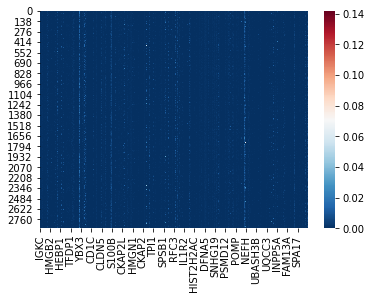

In [94]:
ax = sns.heatmap(df, cmap="RdBu_r")

In [103]:
list = df.mean().sort_values(ascending = False)[0:100].index.tolist()

In [ ]:
for i in range(len(list)):
  print(list[i])

In [107]:
meta["perturb"].value_counts().index.tolist()

['CD4 T',
 'Mono/DC',
 'CD8 T',
 'B cell',
 'Progenitor cells',
 'NK',
 'MAIT',
 'gdT']

In [106]:
idex = meta[meta["perturb"] == "CD4 T"].index.tolist()

In [109]:
cell_types = meta["perturb"].value_counts().index.tolist()

In [112]:
attention_list = []
df_list = []
for i, cell_type in zip(range(8), cell_types):
  idex = meta[meta["perturb"] == cell_type].index.tolist()
  attention = attentions[idex]
  attention_list.append(attention)
  df = pd.DataFrame(attention)
  df.columns = newdata.columns[0:-1]
  df_list.append(df)

In [114]:
df_list[0]

,IGKC,HBA2,HBB,HBA1,IGHA1,IGLC2,JCHAIN,HBM,IGHG1,IGHM,HBD,IGHG3,IGHG2,CA1,PTGDS,IGLC3,MZB1,AHSP,ELANE,HIST1H4C,IGLL1,PRTN3,CA2,MPO,DNTT,HBG2,AZU1,GYPA,PRDX2,HBG1,IGLL5,IGHGP,IGHA2,FAM178B,IGHG4,LYPD2,VPREB1,UBE2C,AL928768.3,APOC1,...,MAP7D2,ARPC1A,FAM46C,SVOPL,TRAV5,TMEM183A,RPL3,LINC00570,BRIX1,DNAJC2,TRBV21-1,LINC00114,RP11-556I14.1,LECT1,SLC16A8,CRIP1,SEL1L3,POLR3H,AMT,SERPINB1,RNF26,RP11-656D10.3,RBP4,MTIF2,INF2,RP11-693J15.5,NAE1,KDELR2,TCEAL2,SPATS2L,INSR,RAD23B,COMMD4,PPARA,PFDN6,PDSS1,BANF1,DDI2,DCAF6,HSPA5
0,3.625429e-04,0.000741,7.017425e-05,8.222996e-04,2.717185e-04,0.000565,0.001948,0.000213,0.000531,0.000129,0.000139,0.000080,0.000626,0.000492,0.001517,0.000350,5.282107e-04,0.000273,0.000441,2.982988e-04,0.002123,0.000187,0.000327,0.000059,0.000967,0.000229,0.000557,0.000357,0.000381,0.000554,0.000271,0.000219,0.000398,0.000197,0.000099,0.001021,0.000771,0.000147,0.000281,0.000139,...,0.000699,1.063395e-04,1.799658e-04,0.000099,0.000089,0.000368,0.004437,0.000147,0.000090,0.000423,0.000105,0.000009,0.000357,0.000052,0.000203,0.000182,0.000685,0.000456,2.974768e-05,0.001002,0.000457,0.000091,0.000231,0.000263,0.000262,0.000848,7.308941e-04,5.783474e-04,0.000892,0.000237,1.208805e-03,0.000349,1.165580e-05,0.000364,0.000221,0.000206,6.255314e-04,0.000151,1.957432e-04,0.002021
1,4.787019e-05,0.000008,8.699012e-07,2.047342e-06,1.881170e-04,0.000150,0.004084,0.000460,0.000442,0.000036,0.000138,0.000070,0.000290,0.000403,0.001078,0.001235,7.899631e-04,0.000173,0.000235,1.307942e-04,0.010057,0.000009,0.000103,0.000006,0.000849,0.000072,0.000627,0.000423,0.000008,0.000228,0.000627,0.000054,0.000052,0.001256,0.000014,0.000203,0.001931,0.000102,0.000884,0.000025,...,0.000337,1.301886e-10,3.643331e-04,0.000042,0.000058,0.000269,0.001797,0.000053,0.000137,0.001425,0.000098,0.000004,0.000742,0.000009,0.000097,0.000323,0.001152,0.000387,9.981541e-06,0.002435,0.000169,0.000108,0.000028,0.000419,0.000156,0.001708,5.550950e-10,3.032730e-04,0.001933,0.000300,1.781173e-09,0.000588,3.934335e-11,0.000929,0.000179,0.000283,1.730815e-03,0.000016,1.210012e-04,0.001391
2,5.771441e-04,0.001282,1.650694e-06,6.219443e-04,1.908592e-04,0.001648,0.003527,0.000213,0.000369,0.000040,0.000061,0.000019,0.000360,0.000346,0.000754,0.000617,4.153741e-04,0.000192,0.000118,1.525376e-04,0.004695,0.000033,0.000142,0.000015,0.000737,0.000056,0.000522,0.000238,0.002602,0.000346,0.000355,0.000103,0.000104,0.000341,0.000036,0.000439,0.000910,0.000059,0.000421,0.000032,...,0.000691,2.470864e-05,6.587312e-05,0.000036,0.000063,0.000515,0.021620,0.000044,0.000052,0.001017,0.000113,0.000004,0.000266,0.000016,0.000063,0.000193,0.000987,0.000188,3.428406e-06,0.002327,0.000252,0.000073,0.000054,0.000255,0.000131,0.001603,4.856774e-04,3.064970e-04,0.001542,0.000053,4.261866e-04,0.000360,6.864670e-05,0.000351,0.000161,0.000090,1.223333e-03,0.000035,5.349120e-05,0.002328
3,5.515799e-04,0.001450,4.791224e-06,7.888000e-04,3.431983e-06,0.001322,0.003721,0.000190,0.000433,0.000042,0.000047,0.000030,0.000447,0.000402,0.000693,0.000623,3.019155e-04,0.000221,0.000112,2.519352e-04,0.002301,0.000042,0.000182,0.000032,0.001075,0.000052,0.000636,0.000197,0.003576,0.000419,0.000306,0.000146,0.000120,0.000250,0.000063,0.000735,0.000712,0.000040,0.000295,0.000039,...,0.000915,3.825019e-05,4.845273e-05,0.000053,0.000071,0.000746,0.000367,0.000046,0.000040,0.000997,0.000124,0.000005,0.000226,0.000028,0.000046,0.000177,0.001038,0.000122,5.265569e-06,0.002032,0.000325,0.000064,0.000072,0.000222,0.000173,0.001918,5.257147e-07,4.101212e-04,0.001680,0.000042,5.060966e-04,0.000299,1.016652e-04,0.000303,0.000176,0.000075,1.649148e-03,0.000075,4.364994e-05,0.002821
4,3.416761e-07,0.001466,2.256016e-03,6.935124e-04,1.743330e-04,0.002419,0.002877,0.000225,0.000350,0.000023,0.000023,0.000029,0.000317,0.000373,0.000259,0.001037,2.273319e-04,0.000128,0.000036,2.134617e-04,0.002563,0.000010,0.000092,0.000016,0.001148,0.000015,0.000473,0.000102,0.000002,0.000225,0.000315,0.000054,0.000037,0.000519,0.0

In [119]:
cell_types

['CD4 T',
 'Mono/DC',
 'CD8 T',
 'B cell',
 'Progenitor cells',
 'NK',
 'MAIT',
 'gdT']

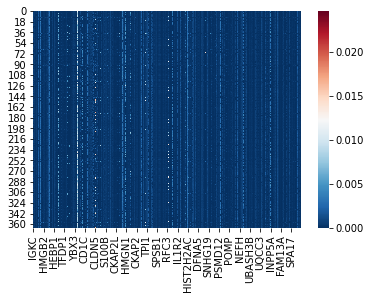

In [117]:
#gdt
ax = sns.heatmap(df_list[7], cmap="RdBu_r")

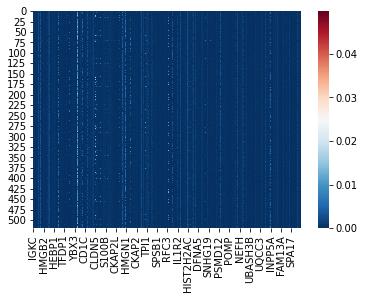

In [118]:
#MAIT
ax = sns.heatmap(df_list[6], cmap="RdBu_r")

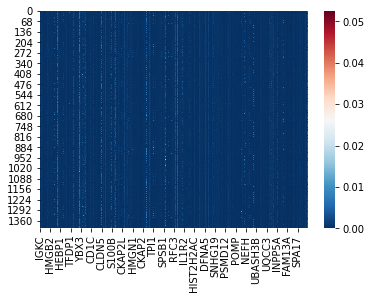

In [115]:
#NK
ax = sns.heatmap(df_list[5], cmap="RdBu_r")

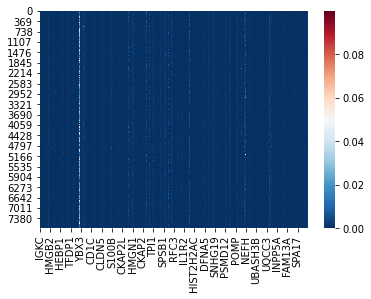

In [120]:
#Mono/DC
ax = sns.heatmap(df_list[1], cmap="RdBu_r")

In [125]:
df_list[4].mean().sort_values(ascending = False)[0:10].index.tolist()

['LYZ',
 'HLA-DRB1',
 'HLA-DRA',
 'MS4A1',
 'TYROBP',
 'RPL3',
 'CD79B',
 'P2RX5',
 'TRBC1',
 'LST1']

In [122]:
list

['LYZ',
 'S100A8',
 'RETN',
 'RPL3',
 'S100A9',
 'S100A6',
 'GLRX',
 'RPS24',
 'GLUL',
 'PEBP1']

In [135]:
df = pd.DataFrame()
whole_list = []
for i, cell_type in zip(range(8), cell_types):
  df[cell_type] = df_list[i].mean().sort_values(ascending = False)[0:10].index.tolist()
  whole_list = whole_list + df_list[i].mean().sort_values(ascending = False)[0:10].index.tolist()

In [141]:
len(set(whole_list))

39

In [144]:
df.to_csv("/content/drive/Shareddrives/Documentation/Jiaxin_Li/Highest_10_genes_40_epochs.csv",index = False)

In [145]:
df

,CD4 T,Mono/DC,CD8 T,B cell,Progenitor cells,NK,MAIT,gdT
0,RPS24,LYZ,HLA-DRA,RPS24,LYZ,HLA-DRA,HLA-DRA,HLA-DRA
1,HLA-DRA,S100A8,RPS24,H2AFY,HLA-DRB1,TRGC2,H2AFY,H2AFY
2,H2AFY,RETN,H2AFY,RPS2,HLA-DRA,PEBP1,JCHAIN,CMC1
3,HLA-DRB1,RPL3,HLA-DRB1,RPL3,MS4A1,H2AFY,PEBP1,PEBP1
4,RPLP1,S100A9,SNRPE,RPS3,TYROBP,KLRG1,HLA-DRB1,JCHAIN
5,SNRPE,S100A6,GAPDH,SNRPE,RPL3,JCHAIN,CMC1,CCL4
6,RPS2,GLRX,PEBP1,SNRPF,CD79B,DUSP2,GZMB,UBB
7,LYZ,RPS24,RPLP1,RPS12,P2RX5,LYZ,IGLL1,SNRPF
8,C1QBP,GLUL,MS4A1,ANP32B,TRBC1,S100A6,XCL2,HLA-DRB1
9,MS4A1,PEBP1,LYZ,GAPDH,LST1,SNRPF,SNRPE,PLAC8


In [147]:
newdata.shape

(30672, 2001)

In [149]:
att = pd.DataFrame(attentions, columns = newdata.columns[0:-1])

In [ ]:
att.to_csv("/content/drive/Shareddrives/Documentation/Jiaxin_Li/Attentions_epoch40.csv")